<b>Task:</b>
- Improve the quality by using the Bayesian Optimisation (hyperopt, optuna)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
# Step 1. Load data
from sklearn.datasets import fetch_california_housing
df = pd.DataFrame(fetch_california_housing(as_frame=True).frame)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


<Axes: >

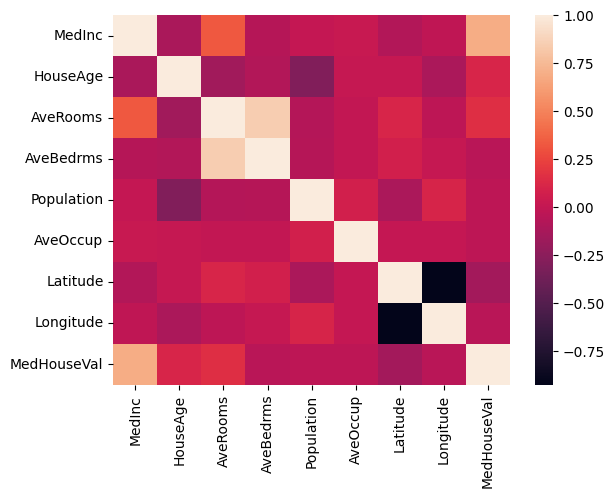

In [6]:
# Step 2. Checking correlation
sns.heatmap(df.corr())

<Axes: >

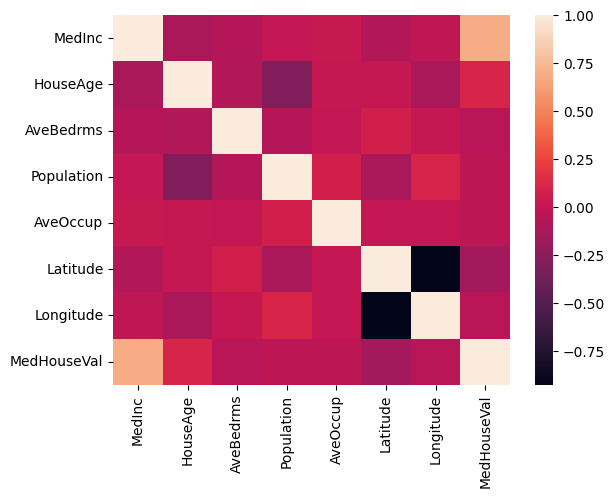

In [7]:
df = df.drop(columns=['AveRooms'])
sns.heatmap(df.corr())

In [8]:
# Step 3. Normalization and split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['MedHouseVal']), df.MedHouseVal, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
# Step 4. Calculate the baseline accuracy.
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score # cross-validation

#score fun
def scorer(model, X,y):
    return mean_squared_error(y, model.predict(X))

svr = SVR()
cross_val_score(svr, X_train, y_train, scoring = scorer, cv=10).mean()

0.3723454700624361

<b>The baseline MSE: 37,2%</b>

In [14]:
# Step 5. Bayesian Optimisation: using hyperopt
from hyperopt import hp, rand, fmin, tpe, Trials, STATUS_OK

list_kernel = ['linear', 'rbf', 'sigmoid']
list_degree = np.arange(1, 12, 2)
list_gamma = ['scale', 'auto']
list_C = [10e-6, 10e-4, 10e-2, 0.1, 1, 10]

# parameters space for looking for
search_space = [
    hp.choice(label='kernel', options=['linear', 'rbf', 'sigmoid']),
    hp.choice(label='degree', options=np.arange(1, 12, 2)),
    hp.choice(label='gamma', options=['scale', 'auto']),
    hp.choice(label='C', options=[10e-6, 10e-4, 10e-2, 0.1, 1, 10])
]


# sample allows you to evaluate the parameter space.
from hyperopt.pyll.stochastic import sample

samples = []

for _ in range(10):
    print(sample(search_space)) # space description (4 params)

('sigmoid', 7, 'auto', 0.1)
('sigmoid', 11, 'scale', 1e-05)
('sigmoid', 11, 'auto', 1)
('rbf', 1, 'auto', 1e-05)
('rbf', 1, 'scale', 1e-05)
('sigmoid', 3, 'scale', 1)
('rbf', 3, 'auto', 0.1)
('rbf', 11, 'auto', 0.1)
('sigmoid', 3, 'scale', 10)
('linear', 3, 'auto', 0.001)


In [15]:
# there is needed to create the function
def objective(params):
  svr = SVR(kernel=params[0], degree=params[1], gamma=params[2], C=params[3])
  scores = cross_val_score(svr, X_train, y_train, scoring = scorer, cv=10)
  return scores.mean()

In [16]:
# tpe.suggest - method Bayesian Optimisation Tree of Parzen Estimators (TPE)
tpe_algo = tpe.suggest

# rand.suggest - Random Search
rand_algo = rand.suggest

# Create two trials objects (Trials - object for storing the search history)
tpe_trials = Trials()  
rand_trials = Trials()   

In [17]:
#run the process of params searching using fmin (Bayesian Optimisation)
tpe_best = fmin(fn=objective, space=search_space, algo=tpe_algo, trials=tpe_trials, 
                max_evals=25)

print(tpe_best)

100%|██████████| 25/25 [40:21<00:00, 96.88s/trial, best loss: 0.34146405545556274] 
{'C': 5, 'degree': 1, 'gamma': 0, 'kernel': 1}


In [19]:
#Get predictictions tpe_best
svr_optimized =  SVR(kernel=list_kernel[tpe_best.get('kernel')], degree=list_degree[tpe_best.get('degree')], gamma=list_gamma[tpe_best.get('gamma')], C=list_C[tpe_best.get('C')]).fit(X_train, y_train)
scorer(svr_optimized, X_test,y_test)

0.3282048912037783

<b>Bayesian Optimisation TPE: 32.8%</b>

In [18]:
# Run 25 evals for Random Search
rand_best = fmin(fn=objective, space=search_space, algo=rand_algo, trials=rand_trials, 
                 max_evals=25)

print(rand_best)

100%|██████████| 25/25 [1:13:01<00:00, 175.27s/trial, best loss: 0.34146405545556274]
{'C': 5, 'degree': 0, 'gamma': 0, 'kernel': 1}


In [20]:
#Get predictictions rand_trials
svr_optimized =  SVR(kernel=list_kernel[rand_best.get('kernel')], degree=list_degree[rand_best.get('degree')], gamma=list_gamma[rand_best.get('gamma')], C=list_C[rand_best.get('C')]).fit(X_train, y_train)
scorer(svr_optimized, X_test,y_test)

0.3282048912037783

<b>Bayesian Optimisation Random Search: 32.8%</b>

In [21]:
# Step 5. Bayesian Optimisation: using optuna
import optuna
from optuna import Trial # special object that allows to assign various hypermarameters
from optuna.samplers import TPESampler, CmaEsSampler  #TPESampler - Tree-structured Parzen Estimator; CmaEsSampler - algorithm on base CMA-ES

#score fun
def scorer(model, X,y):
    return mean_squared_error(y, model.predict(X))


#Define the target function "objective", through arguments it will receive a special object trial. With its help it is possible to assign various hypermarameters
def objective(trial: Trial,X,y) -> float:
    
    param = {
                "kernel" : trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid']),
                'degree':trial.suggest_int('degree', 1, 12, 2),
                'gamma':trial.suggest_categorical('gamma',['scale', 'auto']),
                'C': trial.suggest_float('C', 10e-6, 10.0),
            }
   
    model = SVR(**param)
    return  cross_val_score(model, X, y, scoring = scorer, cv=10).mean()


In [24]:
#  optuna.create_study - study object
study = optuna.create_study(direction='minimize',sampler=TPESampler()) 

# after creating study object, will start optimizing target function objective.
study.optimize(lambda trial : objective(trial,X_train,y_train),n_trials= 25)

#special fields that allow to see the results after training
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

[I 2023-10-16 23:50:10,478] A new study created in memory with name: no-name-5bc2354c-cacd-46c8-b4f1-10546a1ff145
[I 2023-10-16 23:53:14,005] Trial 0 finished with value: 368904.6402411525 and parameters: {'kernel': 'sigmoid', 'degree': 7, 'gamma': 'auto', 'C': 6.204327416439094}. Best is trial 0 with value: 368904.6402411525.
[I 2023-10-17 00:00:15,534] Trial 1 finished with value: 2.3501155167672274 and parameters: {'kernel': 'linear', 'degree': 1, 'gamma': 'auto', 'C': 3.017978525066251}. Best is trial 1 with value: 2.3501155167672274.
[I 2023-10-17 00:03:16,795] Trial 2 finished with value: 285871.7970977473 and parameters: {'kernel': 'sigmoid', 'degree': 9, 'gamma': 'scale', 'C': 5.377889396703899}. Best is trial 1 with value: 2.3501155167672274.
[I 2023-10-17 00:17:04,138] Trial 3 finished with value: 2.352007613055634 and parameters: {'kernel': 'linear', 'degree': 1, 'gamma': 'scale', 'C': 7.789003957508994}. Best is trial 1 with value: 2.3501155167672274.
[I 2023-10-17 00:18:44

Best trial: score 0.3414794988884998,
params {'kernel': 'rbf', 'degree': 5, 'gamma': 'scale', 'C': 9.984979572233778}


In [34]:
#Get predict optuna
svr_optimized =  SVR(**study.best_trial.params).fit(X_train, y_train)
scorer(svr_optimized, X_test,y_test)

0.32822742605412636

<b>Conclusion:</b>

|                          |    MSE          |
|--------------------------|-----------------|
|Baseline                  |     37,2%       |
|hyperopt BO TPE           |     32.8%       |
|hyperopt BO Random Search |     32.8%       |
|optuna BO                 |     32.8%       |